In [1]:
%load_ext autoreload
%autoreload 2

Add the autoreload command so that changes made on the forestplot library can be reflected automatically

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import forestplot as fp

## Exploratory Data Analysis

https://www.cochranelibrary.com/cdsr/doi/10.1002/14651858.CD014624.pub2/full

Wilson et al. (2025) Brexanolone, zuranolone and related neurosteroid GABAA receptor positive allosteric modulators for postnatal depression

<b>250710</b>

Tried this "forestplot" library, it doesn't seem to be what I needed. I think it can't handle Cochrane data pretty well enough.

It seems to malfunction when there are more than 36 rows in the dataframe...

No, it's not that. The behavior is weird, without specifying the "Weight" column, it cuts off the first two rows of the df... it's not a datatype problem, if we specify the "Mean" column rather than the "Weight" column, it still cuts off. 

To debug, I try to specify some random columns: "Subgroup" is fine. "GIV SE" is not. "CI end" is not. "Study" is not. "O-E" is not. "Variance" is not. But as long as I have "Weight", I can safely specify any other columns to display.

I think there are big problems with this library...

I can take a look at its source code to learn about how to align the texts in table-like format, but I'll come up with my own functions.

<b>250711</b>

Pull the "forestplot" library from GitHub and edit my own version, try to implement the feature we need and fix the strange bugs.

Before digging into forestplot, there is something more important: derive the "total" statistics.

If an analysis has subgroups, they are in the "-subgroup-estimates.csv" file.

If it doesn't have subgroups, the estimates are in the "-overall-estimates-and-settings.csv" file

SIDE TASK: learn how to derive these stats
* The answer is Mantel-Haenszel random-effects model, as labeled in the figures!
* https://www.cochrane.org/authors/handbooks-and-manuals/handbook/current/chapter-10#section-10-4-1
* The 


In [20]:
# an example of the weighted total calculation using Mantel-Haenszel random-effects model
# CD014624 analysis 2.1, subgroup 2

x1 = 49
xN1 = 77
x2 = 47
xN2 = 98

y1 = 33
yN1 = 76
y2 = 24
yN2 = 98

w1 = 0.603
w2 = 0.397
e1 = 1.47
e2 = 1.96

rx1 = x1/xN1
rx2 = x2/xN2
ry1 = y1/yN1
ry2 = y2/yN2

logr1 = np.log(rx1/ry1)
logr2 = np.log(rx2/ry2)
ans = np.exp(w1*logr1 + w2*logr2) # THIS IS IT!!

print(ans)

1.6442960216275762


In [7]:
data_dir = "forest_plot_practice"
data_package_ID = "CD014624"

df = pd.read_csv(f"{data_dir}/{data_package_ID}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-data-rows.csv")
est = pd.read_csv(f"{data_dir}/{data_package_ID}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-overall-estimates-and-settings.csv")
est_subgroup = pd.read_csv(f"{data_dir}/{data_package_ID}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-subgroup-estimates.csv")


Group: 1, Analysis: 1
(38, 25)
   Analysis group  Analysis number                      Analysis name  \
0               1                1  Depression response (early phase)   
1               1                1  Depression response (early phase)   
2               1                1  Depression response (early phase)   
3               1                1  Depression response (early phase)   
4               1                1  Depression response (early phase)   

                Subgroup  Subgroup number         Applicability  \
0  2 hours post-infusion              1.0  SUBGROUP_AND_OVERALL   
1  2 hours post-infusion              1.0  SUBGROUP_AND_OVERALL   
2  2 hours post-infusion              1.0  SUBGROUP_AND_OVERALL   
3  4 hours post-infusion              2.0  SUBGROUP_AND_OVERALL   
4  4 hours post-infusion              2.0  SUBGROUP_AND_OVERALL   

                        Study  Study year  GIV Mean  GIV SE  ...  Control SD  \
0                  Kanes 2017        2017      

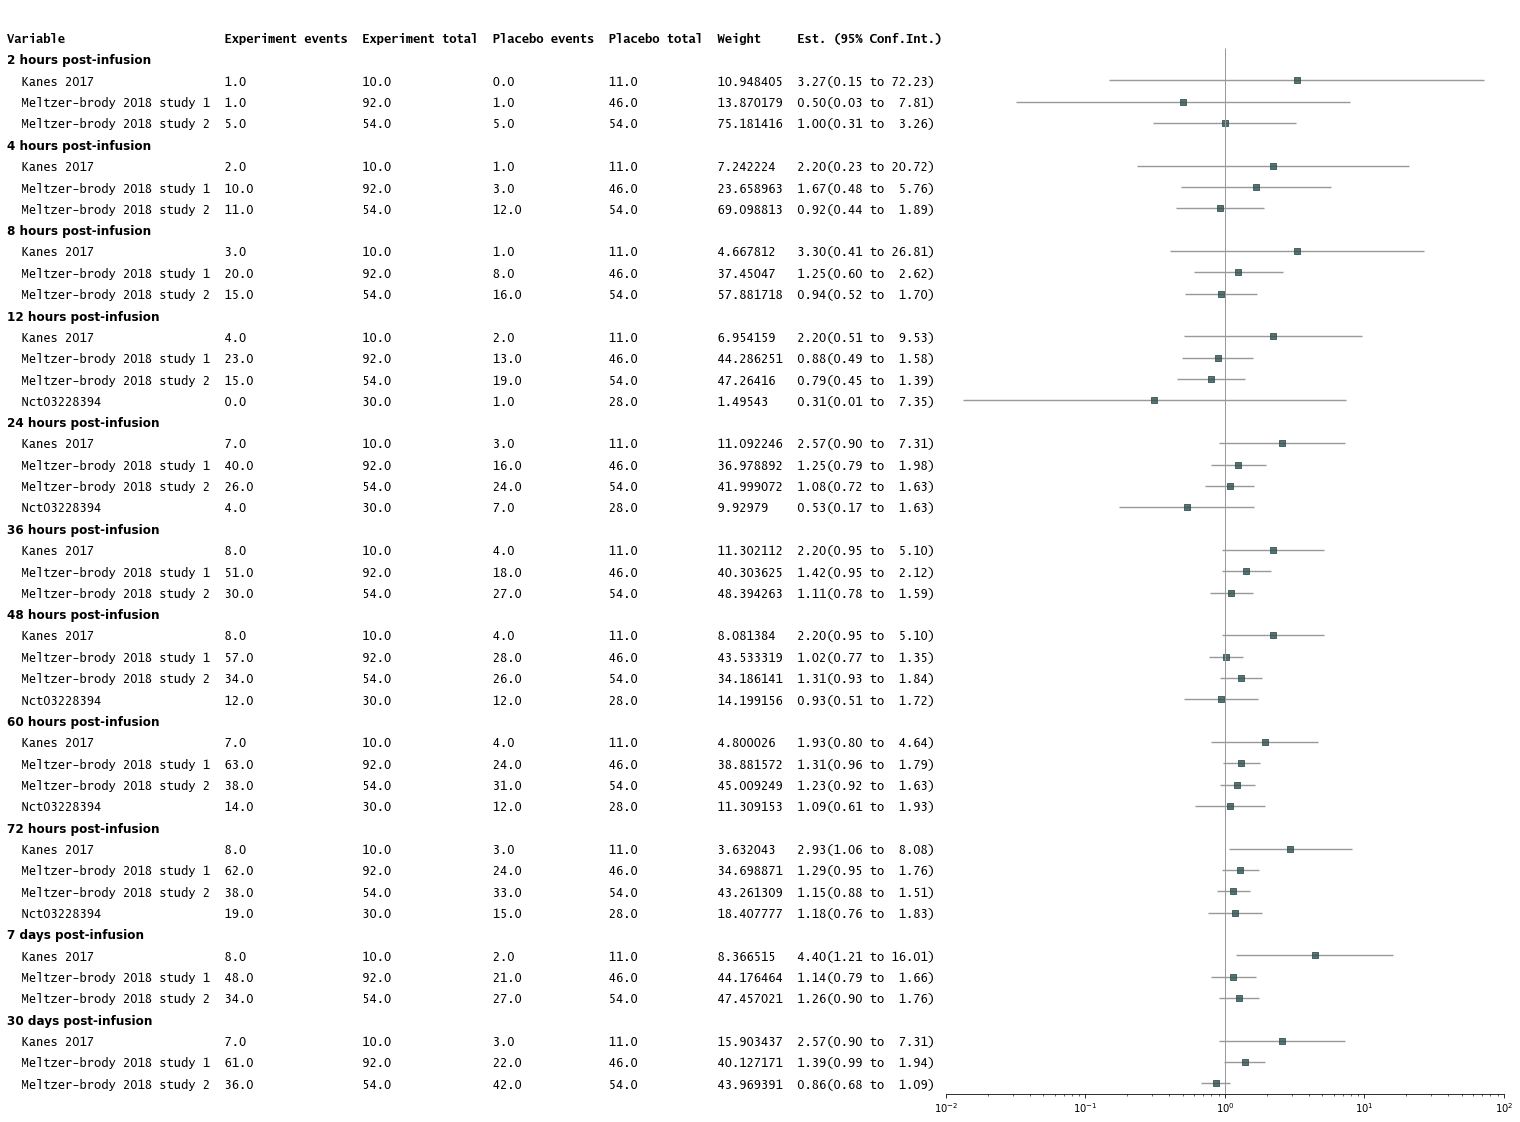

In [5]:
for ag in df["Analysis group"].unique():
    ag_df = df[(df["Analysis group"]==ag)]
    for an in ag_df["Analysis number"].unique():
        an_df = ag_df[ag_df["Analysis number"]==an].reset_index(drop=True)
        print(f"Group: {ag}, Analysis: {an}")
        if an_df["Subgroup"].isna().all():
            an_df["Subgroup"] = ""
            an_df["Subgroup number"] = 0
        
        
        # fp.forestplot(an_df, estimate="Mean", ll="CI start", hl="CI end", capitalize="capitalize", varlabel="Study", groupvar="Subgroup",
        #               annote=["Experimental cases", "Experimental N",  "Control cases", "Control N",  "Weight", "est_ci"], 
        #               annoteheaders=["Experiment events", "Experiment total", "Placebo events", "Placebo total", "Weight", "Est. (95% Conf.Int.)"],
        #               logscale=True, xticks=[0.01, 0.1, 1, 10, 100], figsize=(10,20),
        #               **{"xline":1,
        #                  "xlinecolor":"#999999"
        #                 }
        #              )
        break
    break
        

     n         r          CI95%     p-val   BF10  power       var    hl    ll  \
0  706  0.090373    [0.02 0.16]  0.016309  0.839   0.67       age  0.16  0.02   
1  706  0.048081  [-0.03  0.12]  0.201948  0.106   0.25  clerical  0.12 -0.03   
2  706  0.041229  [-0.03  0.11]  0.273948  0.086   0.19  construc  0.11 -0.03   

    moerror       group                      label  
0  0.069627         age                   in years  
1  0.071919  occupation      =1 if clerical worker  
2  0.068771  occupation  =1 if construction worker  


<Axes: xlabel='Pearson correlation', ylabel='Confidence interval'>

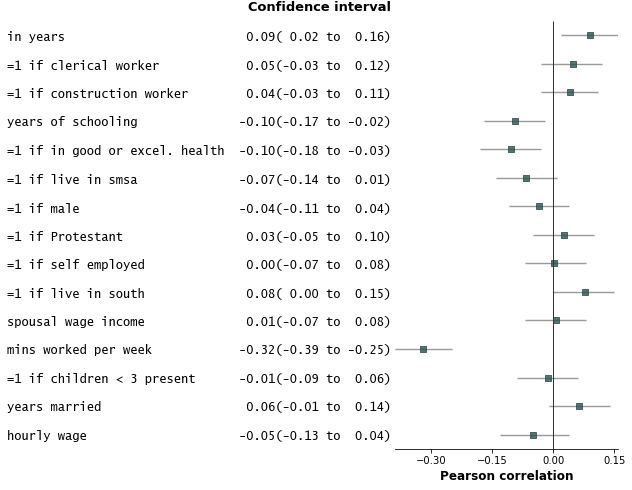

In [20]:
df = fp.load_data("sleep")
print(df.head(3))
fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # columns containing conf. int. lower and higher limits
              varlabel="label",  # column containing variable label
              ylabel="Confidence interval",  # y-label title
              xlabel="Pearson correlation",  # x-label title
              )